In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import sys
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
import skfda

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import BSpline as B


In [9]:
import pandas as pd
import os
os.chdir("C:/Users/Utilisateur/Documents/Master SSD/STAGE RECHERCHE/FDA_python/Functionnal Classifier")
# Lire le fichier CSV
sofa = pd.read_csv('sofa.csv')
T=20
# Attribuer des noms de colonnes personnalisés


# Afficher les noms de colonnes
print(sofa.columns)
grid_points=np.arange(T+1)[1:]
sofa.values.shape


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173',
       'V174'],
      dtype='object', length=174)


(520, 174)

In [13]:
Y_X=torch.from_numpy(sofa.values).float().cuda()

y,x=Y_X[:,0].unsqueeze(1).unsqueeze(2).long(),Y_X[:,1:T+1].reshape(520,1,T)
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(x,y,shuffle=True)
x_train.shape,y_train.shape


(torch.Size([390, 1, 20]), torch.Size([390, 1, 1]))

In [14]:
eval_points=linspace(1,T,5000)
eval_points

array([ 1.        ,  1.00380076,  1.00760152, ..., 19.99239848,
       19.99619924, 20.        ])

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1508\3271225136.py:8: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval = basis.evaluate(eval_points=eval_points)[:, :, 0]


(15, 5000) (390, 15)
torch.Size([15, 5000])


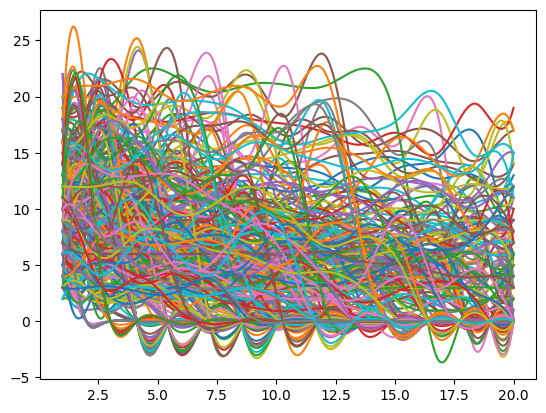

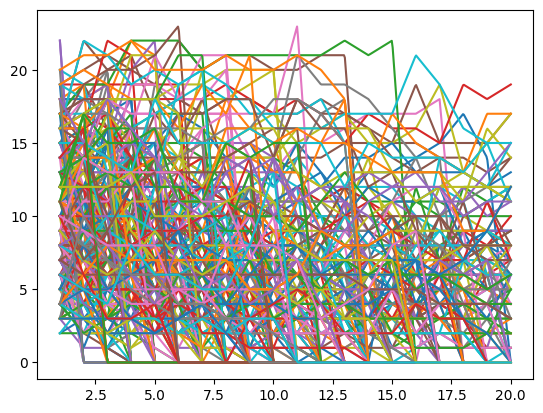

In [1276]:
x_train_grid=fd(x_train[:,0,:].cpu(),grid_points=grid_points)
  # Valeur de départ
  # Valeur de fin

basis=B(knots=linspace(1,T,13),order=4)
# basis=skfda.representation.basis.MonomialBasis()

basis_eval = basis.evaluate(eval_points=eval_points)[:, :, 0]
print(basis_eval.shape,fd(x_train[:,0,:].cpu()).to_basis(basis).coefficients.shape)
basis_fc = torch.from_numpy(basis_eval).float().cuda()
n_basis=basis.n_basis
print(basis_fc.shape)
x_train_grid.to_basis(basis).plot()
plt.show()
x_train_grid.plot()
plt.show()

In [16]:
coefs=fd(x_train[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
coefs_torch=torch.tensor(coefs).cuda()


coefs_torch.shape

torch.Size([390, 11])

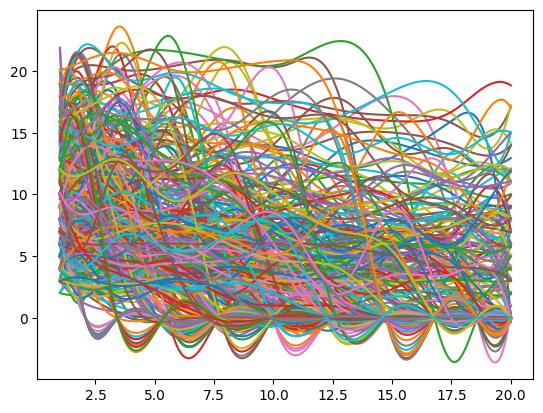

torch.Size([390, 5000])

In [17]:
Recons=torch.matmul(coefs_torch.cuda().float(),basis_fc)
fd(Recons.cpu(),grid_points=eval_points).plot()
plt.show()
Recons.shape

In [1172]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 3)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 3)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [1176]:

granulation=1000
0.02


0.02

In [1374]:
class Smooth_Strides_FCNN(nn.Module):
    def __init__(self):
        super(Smooth_Strides_FCNN,self).__init__()

        self.treshold=nn.Sequential(nn.Threshold(0,value=0),)

        self.convlayer1=nn.Sequential(
            nn.Conv1d(1,128,kernel_size=278,stride=5,padding=12,dilation=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.18),
            
        )
        
        # self.convlayer2=nn.Sequential(
        #     nn.Conv1d(64,128,kernel_size=10,stride=5,padding=0,dilation=1),
        #     nn.BatchNorm1d(128),
        #     nn.LeakyReLU(0.18),
            
        # )
        
        # self.convlayer3=nn.Sequential(

        #     nn.Conv1d(32,20,kernel_size=350,stride=1,padding=1,dilation=1),
        #     nn.BatchNorm1d(20),
        #     nn.LeakyReLU(0.18),
        # )


        self.fc_block=nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_conv_out*128,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.18),
        
            nn.Linear(512,2),

        )
    def Granulator(self,x):
        eval_points=linspace(1,T,granulation)
        basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
        basis_fc = torch.from_numpy(basis_eval).float().cuda()
        coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
        
        coefs_torch=torch.tensor(coefs).cuda()
        Recons_train=torch.matmul(coefs_torch.cuda().float(),basis_fc)
        Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
        return Recons_train

    def forward(self,x):
        Granulated_x_train=self.Granulator(x)
        tresh_out=self.treshold(Granulated_x_train)
        Conv_out=self.convlayer1(tresh_out)
        # Conv_out2=self.convlayer2(Conv_out)
        # Conv_out3=self.convlayer3(Conv_out2)
        # n_conv_out=Conv_out3.shape[1]
        Lin_out=self.fc_block(Conv_out)
        return Lin_out.float().unsqueeze_(2).unsqueeze_(3)


In [1375]:
n_conv_out=150
CNN=Smooth_Strides_FCNN().cuda().apply(weights_init_normal)
Conv_out=CNN.convlayer1(CNN.Granulator(x_train))
# Conv_out2=CNN.convlayer2(CNN.convlayer1(CNN.Granulator(x_train)))
# Conv_out=CNN.convlayer3(CNN.convlayer2(CNN.convlayer1(CNN.Granulator(x_train))))
[CNN.Granulator(x_train).shape,Conv_out.shape,Conv_out2.shape]
# 164960/32


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1508\459299650.py:40: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


[torch.Size([390, 1, 1000]),
 torch.Size([390, 128, 150]),
 torch.Size([390, 128, 35])]

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1508\2354020147.py:40: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


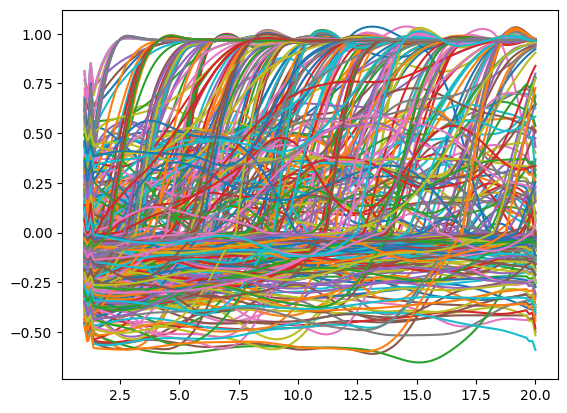

In [1368]:
# convlayer: Elles sont smooth!! (en apparence du moins)
fd(CNN.convlayer1(CNN.Granulator(x_train))[:,0,:].detach().cpu(),grid_points=linspace(1,T,CNN.convlayer1(CNN.Granulator(x_train)).shape[2])).plot()
plt.show()

In [1445]:

CNN=Smooth_Strides_FCNN().cuda().apply(weights_init_normal)



In [1446]:
lr_adam=0.000087 
lr_sgd=0.001 ##SGD 0.01 batch_size=78
batch_size=96

betas=[0.5,0.999]
# optimizer=optim.Adam(CNN.parameters(),lr=lr_adam,betas=betas)
optimizer=optim.SGD(CNN.parameters(),lr=lr_sgd)
loss_function=nn.CrossEntropyLoss()


In [1447]:

from tqdm import tqdm
def train(n_epochs):
    for epoch in tqdm(range(n_epochs)):
        train_loss=torch.tensor(0).cuda().long()
        # print("Epoch:",epoch+1)
        for i in range(int(len(x_train)/batch_size)):
            functions_train=x_train[batch_size*i:batch_size*(1+i),:,:]
            labels_train=y_train[batch_size*i:batch_size*(1+i)]
            optimizer.zero_grad()
            output=CNN(functions_train)
            loss=loss_function(input=output,target=labels_train)
            
            loss.backward()
            optimizer.step()
            train_loss+=loss.long()
    
    return train_loss,loss 

            


        

In [1457]:
train(1)
print("Précision moyenne =",((torch.sum(torch.argmax(CNN(x_test),dim=1)==y_test)/x_test.shape[0])*100).detach().cpu().numpy(),"%")

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1508\459299650.py:40: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 1/1 [00:00<00:00, 34.58it/s]

Précision moyenne = 81.53846 %


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1508\459299650.py:40: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


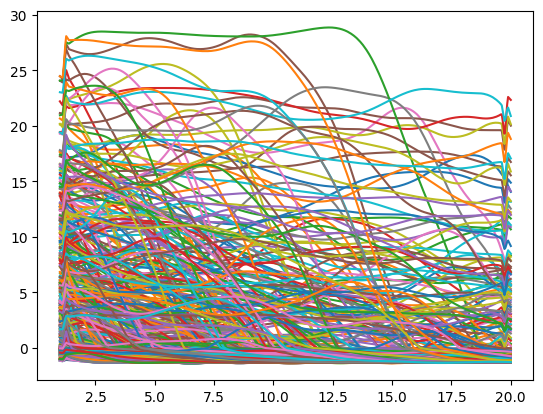

In [1380]:
# convlayer: Elles sont smooth!! (en apparence du moins)
fd(CNN.convlayer1(CNN.Granulator(x_train))[:,0,:].detach().cpu(),grid_points=linspace(1,T,CNN.convlayer1(CNN.Granulator(x_train)).shape[2])).plot()
plt.show()

X_test 1  ème fonction (smooth par Bspline)


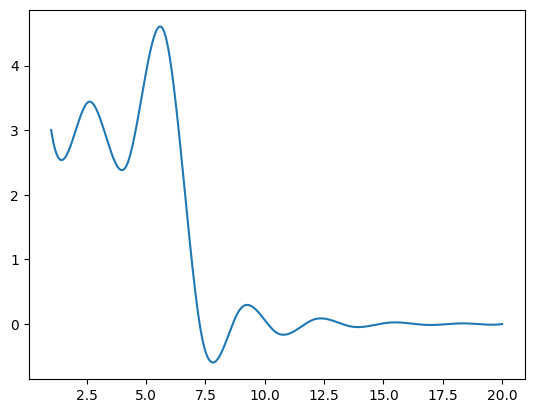

Convlayer1 de x_test 1 ème fonction 1 ème sortie de convolution


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1508\344782136.py:41: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


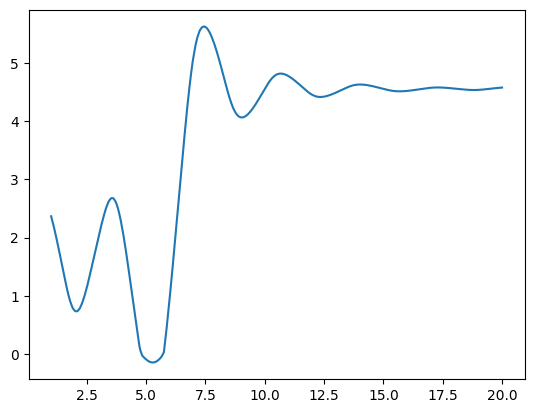

Convlayer1 de x_test 1 ème fonction 2 ème sortie de convolution


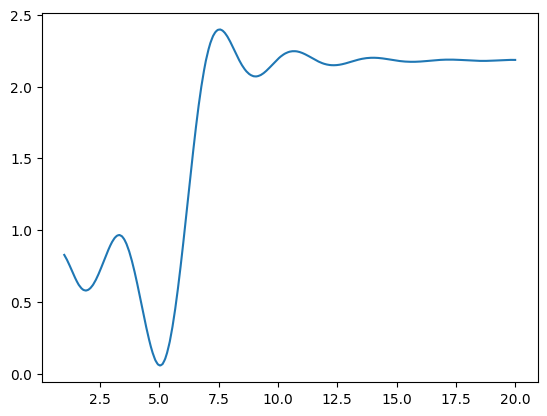

Convlayer1 de x_test 1 ème fonction 3 ème sortie de convolution


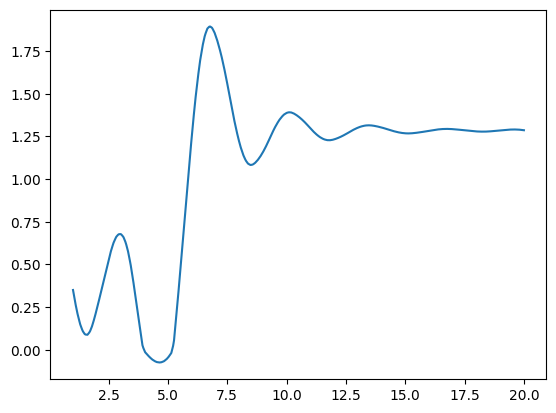

X_test 2  ème fonction (smooth par Bspline)


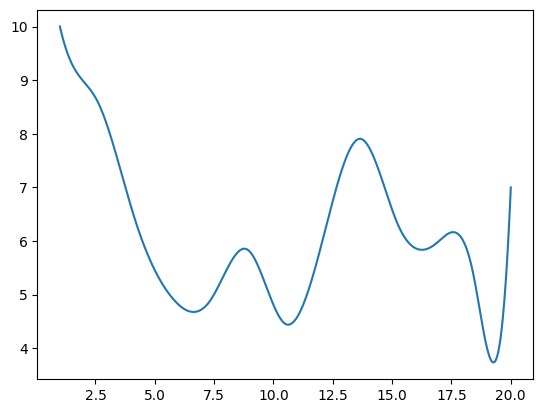

Convlayer1 de x_test 2 ème fonction 1 ème sortie de convolution


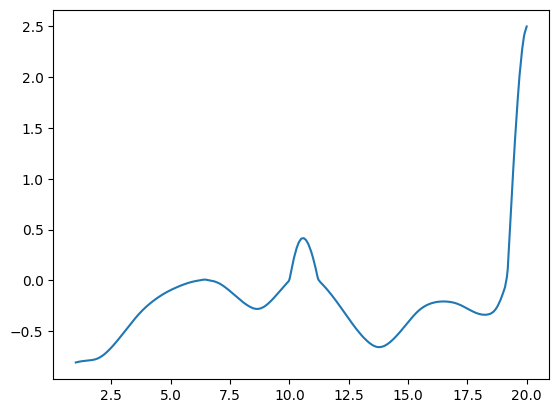

Convlayer1 de x_test 2 ème fonction 2 ème sortie de convolution


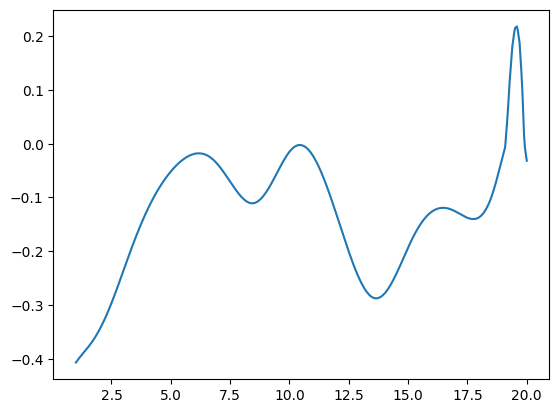

Convlayer1 de x_test 2 ème fonction 3 ème sortie de convolution


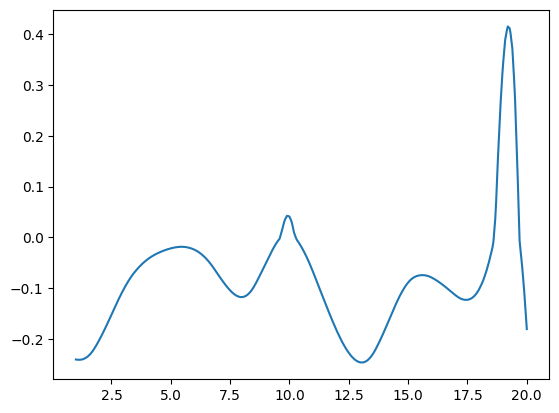

X_test 3  ème fonction (smooth par Bspline)


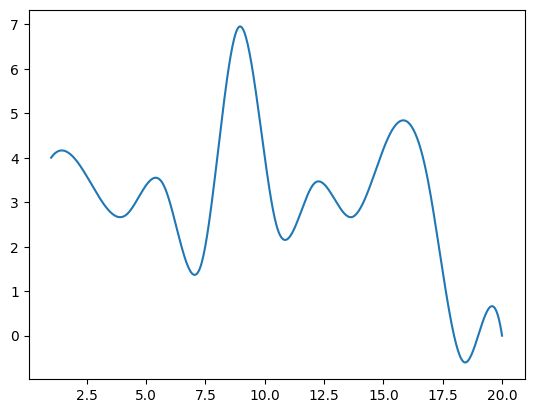

Convlayer1 de x_test 3 ème fonction 1 ème sortie de convolution


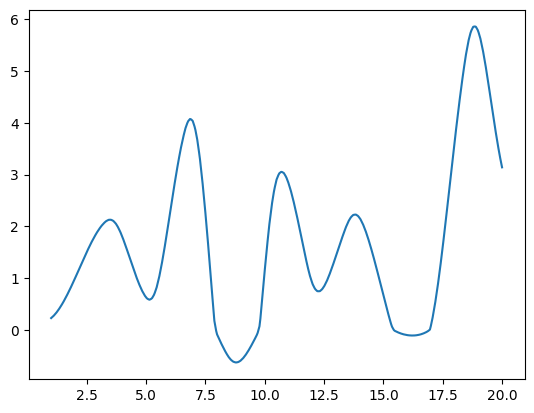

Convlayer1 de x_test 3 ème fonction 2 ème sortie de convolution


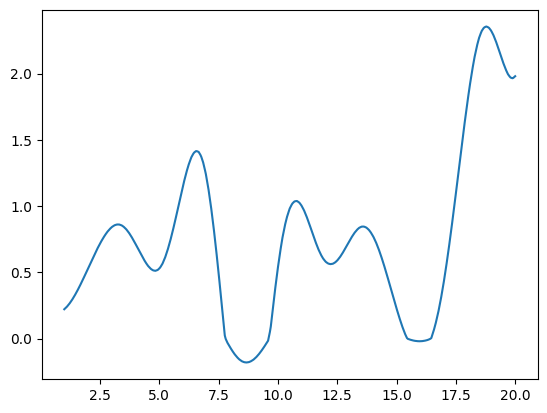

Convlayer1 de x_test 3 ème fonction 3 ème sortie de convolution


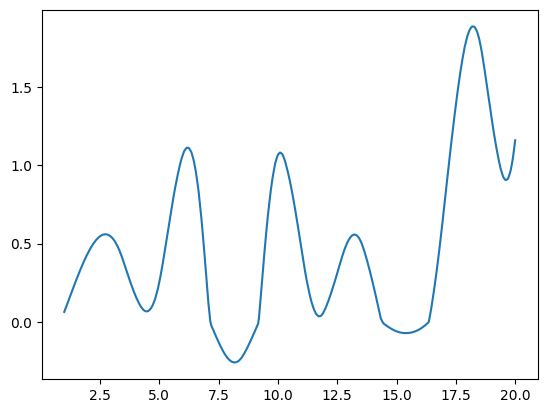

X_test 4  ème fonction (smooth par Bspline)


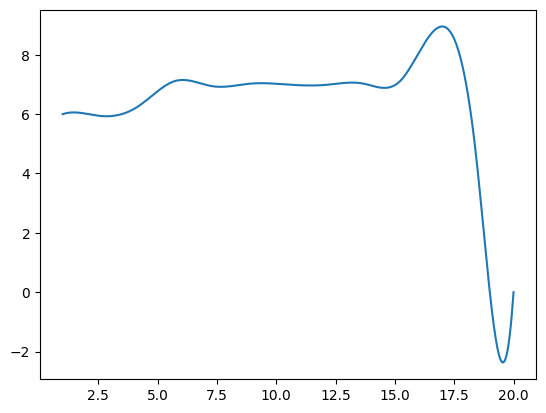

Convlayer1 de x_test 4 ème fonction 1 ème sortie de convolution


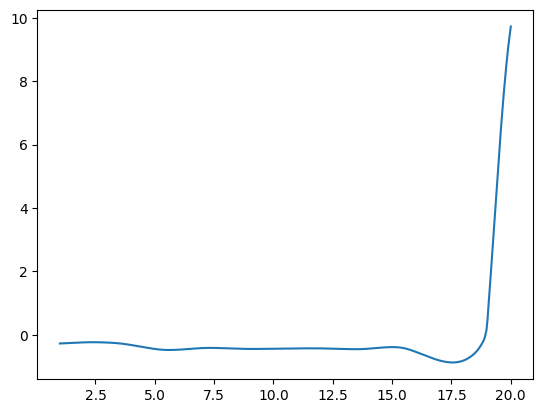

Convlayer1 de x_test 4 ème fonction 2 ème sortie de convolution


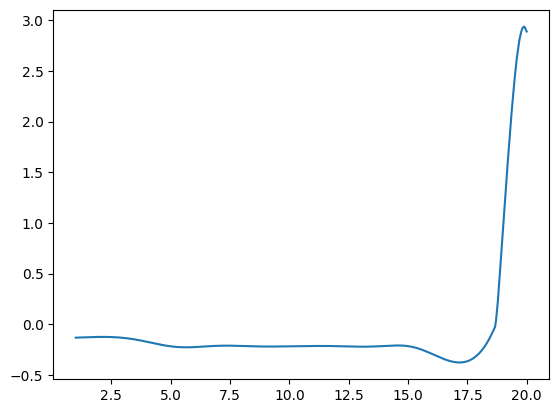

Convlayer1 de x_test 4 ème fonction 3 ème sortie de convolution


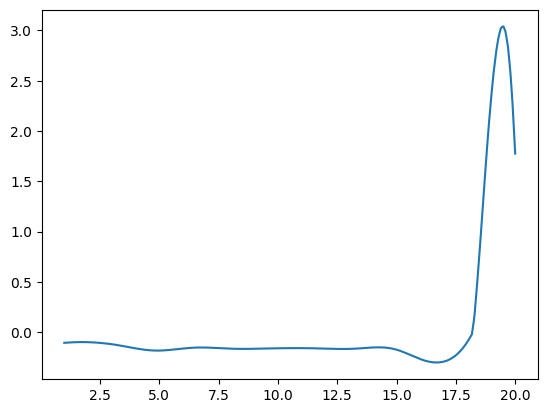

In [1131]:
   # convlayer: Elles sont smooth!! (en apparence du moins)
#ATTENTION, LES CONVLAYER NE SONT PAS FORCEMENT SMOOTH
for i in range(4):
    print("X_test" ,i+1, " ème fonction (smooth par Bspline)")
    fd(x_test[i,0,:].cpu(),grid_points=grid_points).to_basis(basis).plot()
    plt.show()
    for j in range(3):    
        fd(CNN.convlayer1(CNN.Granulator(x_test))[i,j,:].detach().cpu(),grid_points=linspace(1,T,CNN.convlayer1(CNN.Granulator(x_test)).shape[2])).plot()
        print("Convlayer1 de x_test", i+1,"ème fonction",j+1,"ème sortie de convolution")
        plt.show()


In [781]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

31580